In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from classy import Class # import classy module
from scipy.interpolate import interp1d
%matplotlib widget

In [3]:
from pylinger_cosmo import cosmo
from pylinger_pt_single_mode import evolve_perturbations

In [4]:
## Cosmological Parameters
Tcmb = 2.7255
YHe = 0.248
Omegam = 0.276
Omegab = 0.0455
OmegaL = 1.0-Omegam
num_massive_neutrinos = 1
mnu=0.06 #eV
Neff=2.046 # -1 if massive neutrino present
standard_neutrino_neff=Neff+num_massive_neutrinos
h = 0.703
A_s = 2.1e-9
n_s = 0.965
k_p = 0.05


In [5]:
## CLASS setup
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({
    'Omega_b':Omegab,
    'Omega_cdm':(Omegam-Omegab),
    'N_ur':Neff,
    'N_ncdm':num_massive_neutrinos,
    'm_ncdm':mnu,
    'h':h,
    'A_s':A_s,
    'n_s':n_s,
    'tau_reio':0.06, 
    'gauge':'synchronous',
    # 'reio_parametrization' : 'reio_none',
    'k_per_decade_for_pk' : 100,
    'k_per_decade_for_bao' : 100,
    'compute damping scale' : 'yes',
    'tol_perturbations_integration' : 1e-07,
    'tol_background_integration' : 1e-07,
    'hyper_flat_approximation_nu' : 7000,
    'T_cmb':Tcmb,
    'YHe':YHe,
    'output':'mPk,mTk,vTk',
    'lensing':'no',
    'P_k_max_1/Mpc':10.0,
    'z_max_pk':1000.0
  })
# run class
LambdaCDM.compute()
thermo = LambdaCDM.get_thermodynamics()

def get_class_power( fieldname, zout ):
  tk, k, z = LambdaCDM.get_transfer_and_k_and_z()
  TT = interp1d( np.log(1/(1+z)), tk[fieldname], axis=1 )( np.log(1/(1+zout)) ) 
  res =  2*np.pi**2*A_s*(k/k_p*h)**(n_s - 1) * k**(-3) * TT**2 *h**3
  return res, k

In [6]:
## pyLinGer setup
jax.config.update('jax_platform_name', 'cpu')
cp = cosmo(Omegam=Omegam, Omegab=Omegab, OmegaL=OmegaL, H0=100*h, Tcmb=Tcmb, YHe=YHe, Neff=Neff, Nmnu=num_massive_neutrinos, mnu=mnu )


Metal device set to: AMD Radeon Pro 5500M

systemMemory: 32.00 GB
maxCacheSize: 1.99 GB



In [8]:

nmodes = 10
kmin = 1e-3
kmax = 1e-1

y, kmodes = evolve_perturbations( param=cp.param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=jnp.array([1e-2]) )


ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * one axis had size 2050: axis 0 of argument y0_k[0] of type float32[2050];
  * one axis had size 10: axis 0 of argument y0_k[1] of type float32[10]

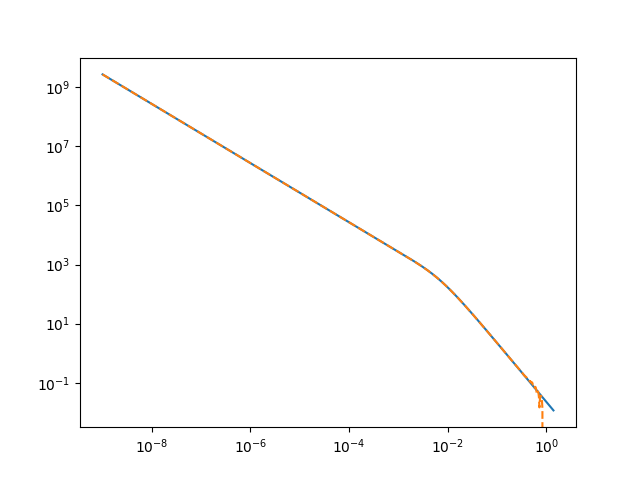

In [8]:
fig, ax  = plt.subplots()
xe = cp.param['th']['xe']
fe = (1.0 - YHe) * xe / (1.0 - 0.75 * YHe + (1.0 - YHe) * xe)
# ax.loglog( cp.param['th']['a'], fe )
ax.loglog( cp.param['th']['a'], cp.param['th']['tb'] )
ax.loglog( astored, tbstored, '--' )
# ax.semilogx( cp.param['th']['a'],  Tcmb / cp.param['th']['a'] - cp.param['th']['tb']) 
# ax.loglog( cp.param['th']['a'], Tcmb / cp.param['th']['a'] ) 

In [ ]:
## evaluate the power spectra
iout = 1
print(f'pyEB zout={1/y[0,0,iout]-1}')
zout = 1/y[0,0,iout]-1

Pkc = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,3,iout]**2 
Pkb = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,5,iout]**2 
Pkg = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,7,iout]**2 

Pkc_CLASS, k_CLASS = get_class_power('d_cdm', zout)
Pkb_CLASS, k_CLASS = get_class_power('d_b', zout)

pyEB zout=73.02492582346132


(0.0001, 10)

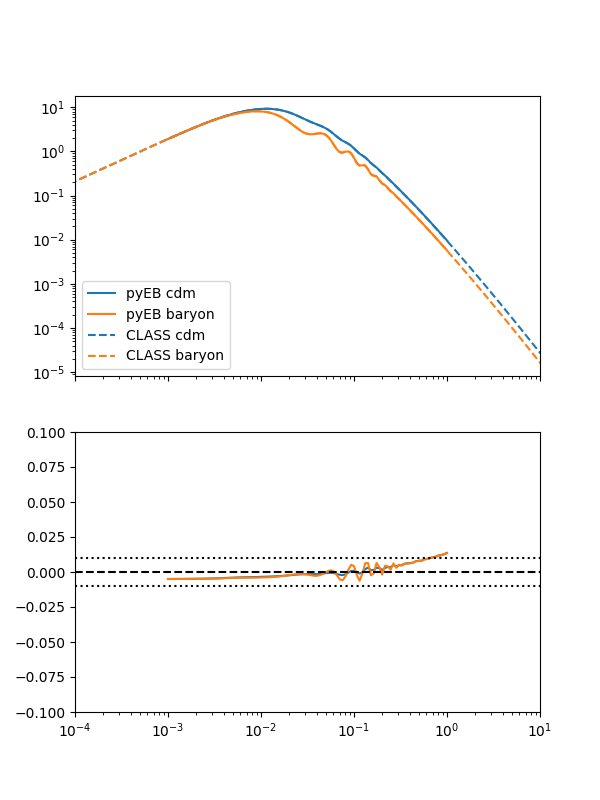

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6,8) )
fac = 2.5
# fac = 2*np.pi**2/ (2*np.pi)**1.5 
ax[0].loglog( kmodes, Pkc*fac, label='pyEB cdm', color='C0')
# ax.loglog( kmodes, Pkc_CAMB, label='CAMB cdm', color='C0', ls='--')
ax[0].loglog( kmodes, Pkb*fac, label='pyEB baryon', color='C1') 
# ax.loglog( kmodes, Pkb_CAMB, label='CAMB baryon', color='C1', ls='--')
ax[0].loglog( k_CLASS, Pkc_CLASS, label='CLASS cdm', ls='--', color='C0')
ax[0].loglog( k_CLASS, Pkb_CLASS, label='CLASS baryon', ls='--', color='C1')
ax[0].legend()

ax[1].semilogx( kmodes, Pkc*fac/np.exp(np.interp( np.log(kmodes), np.log(k_CLASS), np.log(Pkc_CLASS) ))-1.0, label='cdm err', color='C0')
ax[1].semilogx( kmodes, Pkb*fac/np.exp(np.interp( np.log(kmodes), np.log(k_CLASS), np.log(Pkb_CLASS) ))-1.0, label='baryon err', color='C1')

ax[1].set_ylim((-0.1,0.1))
ax[1].axhline(0.0, ls='--', color='k')
ax[1].axhline(0.01, ls=':', color='k')
ax[1].axhline(-0.01, ls=':', color='k')

ax[1].set_xlim((1e-4,10))

# ax.loglog( kmodes, Pkg, label='pyEB photon', color='C2') 
# ax.set_xlim((1e-3,5))

Text(0.5, 0, '$a$')

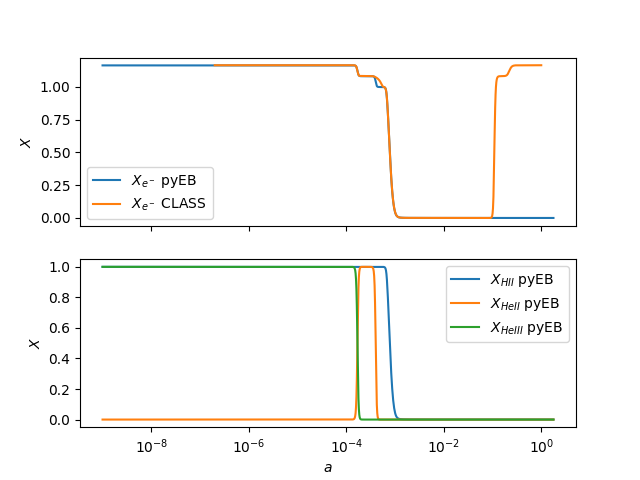

In [25]:
fg, ax = plt.subplots(2,sharex=True)
# ax[0].semilogx( cp.get_a(th.tau), th.xe, label='$X_{e^-}$' )
ax[0].semilogx( cp.th.aexp, cp.th.xe, label='$X_{e^-}$ pyEB' )
ax[0].semilogx( 1/(1+thermo['z']), thermo['x_e'], label='$X_{e^-}$ CLASS' )
ax[1].semilogx( cp.th.aexp, cp.th.xHII, label='$X_{HII}$ pyEB' )
ax[1].semilogx( cp.th.aexp, cp.th.xHeII, label='$X_{HeII}$ pyEB' )
ax[1].semilogx( cp.th.aexp, cp.th.xHeIII, label='$X_{HeIII}$ pyEB' )
for a in ax: 
  a.legend()
  a.set_ylabel('$X$')

ax[1].set_xlabel('$a$')

In [ ]:
import jax.numpy as jnp
import math
import jax

In [ ]:
def nu2( a : float, amnu : float, lmaxnu : int, psi0, psi1, psi2 ):
    const = 7/120 * math.pi**4 
    qmax = 25.0
    # MAXJ=3 stops Richardson extrapolation at three levels, so that the
    # integration scheme is 8th-order Newton-Cotes.
    MAXITER = 7
    MAXJ = 3

    g0 = np.zeros((4))
    gmax = np.zeros((4))
    g = np.zeros((4,MAXJ+1))
    
    if nqmax==0:
      drhonu=0.0
      fnu=0.0
      dpnu=0.0
      shearnu=0.0
      return drhonu,fnu,dpnu,shearnu
    
    # Compute the integrals
    nqmax = 2**MAXITER
    # q is the comoving momentum in units of k_B*T_nu0/c.
    # Integrate up to qmax and then use asymptotic expansion for remainder.
    h=qmax/2
    q=qmax
    aq=a*amnu/q
    v=1.0/jnp.sqrt(1.0+aq*aq)
    qdn=h*q*q*q/(jnp.exp(q)+1.0)
    gmax = jnp.array([qdn*psi0[-1]/v, qdn*psi0[-1]*v, qdn*psi1[-1], qdn*psi2[-1]*v])
    g[:,0] = gmax
    gf = jnp.copy(gmax)
    nint=1
    nn=nqmax//2
    for iter in range(MAXITER):
      # Calculate next trapezoidal rule approximation to integral.
      g0 = jnp.zeros((4))
      for k in range(nint):
        q=(k+k+1)*h
        iq=(k+k+1)*nn
        aq=a*amnu/q
        v=1.0/jnp.sqrt(1.0+aq**2)
        qdn=h*q**3/(jnp.exp(q)+1.0)
        g0.at[0].set( g0[0]+qdn*psi0[iq]/v )
        g0.at[1].set( g0[1]+qdn*psi0[iq]*v )
        g0.at[2].set( g0[2]+qdn*psi1[iq] )
        g0.at[3].set( g0[3]+qdn*psi2[iq]*v )
	
      g0 = 0.5 * g[:,0] + g0
      h = 0.5 * h
      nint = nint + nint
      nn = nn // 2
      jmax = min(iter,MAXJ)
      fourj = 1.0
      for j in range(jmax):
        # Use Richardson extrapolation.
        fourj = 4.0 * fourj
        newg0 = g0 + (g0 - g[:,j])/(fourj-1.0)
        g[:,j] = g0
        g0 = newg0
      err = 1.0-gmax/g0
      gmax = g0
      g[:,jmax] = g0

    drhonu = (g0[0] + gf[0] * 2 / gmax) / const
    dpnu = (g0[1] + gf[1] * 2 / gmax) / const / 3.0
    fnu = (g0[2] + gf[2] * 2 / gmax) / const
    shearnu = (g0[3] + gf[3] * 2 / gmax) / const * 2.0/3.0

    return drhonu,fnu,dpnu,shearnu

In [ ]:
a = jnp.linspace(1e-3,1,100)
v = jnp.linspace(1,2,10)
A = np.ones((8,))
b = np.array([1,2,3])

A[:,None] * b[None,:]

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])